In [89]:
import openfermion
import openfermionpyscf
from openfermion import MolecularData
from openfermionpyscf import run_pyscf
from openfermion.ops import FermionOperator, QubitOperator
from openfermion.transforms import jordan_wigner, bravyi_kitaev
from openfermion.transforms import get_fermion_operator
from openfermion.circuits import (uccsd_singlet_get_packed_amplitudes,
                               uccsd_singlet_generator, uccsd_generator,
                               uccsd_convert_amplitude_format)
import numpy as np
import cs_vqe as c
import itertools
import qubit_conversion as q_conv
from openfermion.linalg import LinearQubitOperator

In [90]:
import ast
import matplotlib
import matplotlib.pyplot as plt

f = open("hamiltonians.txt","r")
hamiltonians = ast.literal_eval(f.read())
f.close()

for h in hamiltonians.keys():
    print(h, '# qubits:', hamiltonians[h][1], 'A terms:', hamiltonians[h][5][3][1])

H2-S1_STO-3G_singlet # qubits: 18 A terms: ['IIZZZZZZZXIIIIIIII', 'IIIIIIIIIZIIIIIIII']
C1-O1_STO-3G_singlet # qubits: 16 A terms: ['IIZZZZZXIIIIIIII', 'IIIIIIIZIIIIIIII']
H1-Cl1_STO-3G_singlet # qubits: 16 A terms: ['IIZZZZZXIIIIIIII', 'IIIIIIIZIIIIIIII']
H1-Na1_STO-3G_singlet # qubits: 16 A terms: ['IIZZZZZZZXIIIIII', 'IIIIIIIIIZIIIIII']
H2-Mg1_STO-3G_singlet # qubits: 17 A terms: ['IIIZZIIZXZZIIZZZZ', 'IIIIIIIIZIIIIIIII']
H1-F1_3-21G_singlet # qubits: 18 A terms: ['IIIIZZZZZXZZIIIIII', 'IIZIIIIIZZIIIIIIII']
H1-Li1_3-21G_singlet # qubits: 18 A terms: ['IIIIZZZZIIZXIIIIII', 'IIZIIIIIIIZZIIIIII']
Be1_STO-3G_singlet # qubits: 5 A terms: ['IIIXI', 'IIIZI']
H1-F1_STO-3G_singlet # qubits: 8 A terms: ['IIXZZZZZ', 'IIZIIIII']
H1-Li1_STO-3G_singlet # qubits: 8 A terms: ['IIIIIXZZ', 'ZZIZIZIZ']
Ar1_STO-3G_singlet # qubits: 13 A terms: ['IIIZZZZZXZZZZ', 'IIIIIIIIZIIII']
F2_STO-3G_singlet # qubits: 15 A terms: ['IIIIIIIIIIIIZII', 'IIIIIIIIIIIXXYY']
H1-O1_STO-3G_singlet # qubits: 8 A terms: ['IIX

In [91]:
speciesname = 'H2-O1_STO-3G_singlet'

encoding = hamiltonians[speciesname][0] # in this dataset, always 'JW' for Jordan-Wigner, but leaves room for trying Bravyi-Kitaev as well
num_qubits = hamiltonians[speciesname][1] # number of qubits (all of these Hamiltonians have been tapered for molecular symmetries)
ham = hamiltonians[speciesname][2] # full Hamiltonian
ham_noncon = hamiltonians[speciesname][3] # noncontextual part of Hamiltonian, found by greedy DFS
true_gs = hamiltonians[speciesname][4] # ground state energy of full Hamiltonian (in Hartree)
gs_noncon = hamiltonians[speciesname][5] # list containing information about noncontextual ground state: zeroth entry is ground state energy of noncontextual part of Hamiltonian

print('number of qubits:', num_qubits)
print('true ground state energy:', true_gs)
print('noncontextual approximation to ground state energy:', gs_noncon[0])
#print(ham_noncon)

number of qubits: 10
true ground state energy: -83.92870248174707
noncontextual approximation to ground state energy: -83.87422390061549


In [92]:
model = c.quasi_model(ham_noncon)
fn_form = c.energy_function_form(ham_noncon, model)
gs_noncon = c.find_gs_noncon(ham_noncon)
gs_noncon_energy = gs_noncon[0]
ep_state = gs_noncon[1]
ham_context = {p:c for p,c in ham.items() if p not in ham_noncon}
print(c.csvqe_approximations_heuristic(ham, ham_noncon, num_qubits, true_gs))
#c.contextualQ_ham(ham_context)

[-83.92870248174707, [-83.8742239006154, -83.8775347638023, -83.89065311104847, -83.89785356786004, -83.91205889216381, -83.91813131301478, -83.92761703951156, -83.92862837750944, -83.92865354102835, -83.92870248174684, -83.9287024817466], [0.054478581131661485, 0.05116771794476449, 0.03804937069860159, 0.030848913887027152, 0.016643589583253515, 0.010571168732283809, 0.0010854422355066617, 7.410423762621576e-05, 4.8940718713197384e-05, 2.2737367544323206e-13, 4.689582056016661e-13], [4, 0, 3, 2, 5, 6, 1, 8, 7, 9]]


In [93]:
print('commuting generators:',model[0], '\n')
print('anticommuting generators:',model[1], '\n')
print('Minimising configuration:', gs_noncon[1])
#print('term reconstruction:',model[2], '\n')

commuting generators: ['ZIIIIIIIII', 'IZIIIIIIII', 'IIZIIIIIII', 'IIIZIIIIII', 'IIIIZIIIII', 'IIIIIIZIII', 'IIIIIIIZII', 'IIIIIIIIZI', 'IIIIIIIIIZ'] 

anticommuting generators: ['IIIIZXZZZZ', 'IIIIIZIIII'] 

Minimising configuration: [[1, -1, -1, -1, -1, -1, -1, -1, -1], [9.576858245891391e-08, -0.9999999999999954]]


In [94]:
A = {p:ep_state[1][index] for index, p in enumerate(model[1])}
A

{'IIIIZXZZZZ': 9.576858245891391e-08, 'IIIIIZIIII': -0.9999999999999954}

In [95]:
def ontic_prob(ep_state, ontic_state):
    
    if ep_state[0] != ontic_state[0]:
        return 0
    
    else:
        prod = 1
        for index, r in enumerate(ep_state[1]):
            f = 1/2 * abs(r + ontic_state[1][index])
            prod *= f
        
        return prod    

def epistemic_dist(ep_state):
    size_G = len(ep_state[0])
    size_Ci = len(ep_state[1])
    size_R = size_G + size_Ci
    
    ep_prob = {}
    
    ontic_states = list(itertools.product([1, -1], repeat=size_R))
    
    for o in ontic_states:
        o_state = [list(o[0:size_G]), list(o[size_G:size_R])]
        o_prob = ontic_prob(ep_state, o_state)
        
        if o_prob != 0:
            ep_prob[o] = o_prob
    
    return ep_prob

In [96]:
epistemic_dist(ep_state)

{(1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1): 1.1379787092233828e-15,
 (1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1): 0.5000000478842901,
 (1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1): 1.137978491258188e-15,
 (1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1): 0.49999995211570764}

In [97]:
r1 = ep_state[1][0]
r2 = ep_state[1][1]
#t = np.arctan((r2 + 1) / r1)
r1, r2

(9.576858245891391e-08, -0.9999999999999954)

In [98]:
generators = model[0]

generators

['ZIIIIIIIII',
 'IZIIIIIIII',
 'IIZIIIIIII',
 'IIIZIIIIII',
 'IIIIZIIIII',
 'IIIIIIZIII',
 'IIIIIIIZII',
 'IIIIIIIIZI',
 'IIIIIIIIIZ']

In [99]:
import itertools
from itertools import chain, combinations
from copy import deepcopy
import math

def bin_to_int(bits):
    bit_string = deepcopy(bits)
    
    if type(bit_string) == str:
        bit_string = [int(b) for b in bit_string]
        
    for index, b in enumerate(bit_string):
        bit_string[index] = b * 2 ** (len(bit_string)-index-1)
    
    return sum(bit_string)


def add_eigenstate(r1, r2, index, num_qubits, theta=0, n=0, custom_amp=None):
    """
    """
    B = list(itertools.product([0,1], repeat=num_qubits))
    b1 = list(B[index])
    b2 = deepcopy(b1)
    b2[5] = (b2[5]+1)%2
    i1 = bin_to_int(b1)
    i2 = bin_to_int(b2)
    
    q0 = b1[9]
    q1 = b1[8]
    q2 = b1[7]
    q3 = b1[6]
    q4 = b1[5]
    q5 = b1[4] 

    parity=q0+q1+q2+q3+q5
    
    amp_ratio = (1 + r2 * (-1)**q4) / (r1 * (-1)**(parity))
    t = ((-1)**n)*np.arctan(amp_ratio)
    psi = [0 for i in range(2**num_qubits)]
    
    if custom_amp is None:   
        psi[i1] = np.sin(t)*np.exp(1j*theta)
        psi[i2] = np.cos(t)*np.exp(1j*(theta - n*np.pi))
    else:
        psi[i1] = custom_amp[0]
        psi[i2] = custom_amp[1]
        
    return np.array(psi)


def expectation(op, state):
    state = np.array(state)
    conj_state = np.conjugate(state)
    O = LinearQubitOperator(op, num_qubits)
    
    O_state = O.matvec(state)
    expect = conj_state.dot(O_state)
    
    return expect


def discard_generator(ham_noncon, ham_context, generators):
    new_ham_noncon = deepcopy(ham_noncon)
    new_ham_context = deepcopy(ham_context)
    
    Z_indices = [g.index('Z') for g in generators]
    removed=[]
    
    for index in Z_indices:
        for p in ham_noncon:
            if p not in removed:
                if p[index] == 'Z':
                    new_ham_context[p] = ham_noncon[p]
                    del new_ham_noncon[p]
                    removed.append(p)
            
    return new_ham_noncon, new_ham_context


def rotate_operator(rotations, op):
    rot_op = {}
    
    for p in op.keys():
        p_ref = deepcopy(p)
        parity = 1
        coeff = op[p]
        for r in rotations:
            rotate_p = c.apply_rotation(r, p)
            p = list(rotate_p.keys())[0]
            parity *= rotate_p[p]
        
        rot_op[p] = parity * coeff
        
    return rot_op

def rotate_hamiltonian(rotations, ham, ham_noncon, ham_context):
    
    rot_ham={}
    rot_ham_noncon={}
    rot_ham_context={}

    for p in ham.keys():
        p_ref = deepcopy(p)
        parity = 1
        coeff = ham[p]
        for r in rotations:
            rotate_p = c.apply_rotation(r, p)
            p = list(rotate_p.keys())[0]
            parity *= rotate_p[p]
        
        rot_ham[p] = parity * coeff
        if p_ref in ham_noncon.keys():
            rot_ham_noncon[p] = parity * coeff
        else:
            rot_ham_context[p] = parity * coeff
            
    return rot_ham, rot_ham_noncon, rot_ham_context


def rotate_state(rotations, state):
    
    rot_state = deepcopy(state)
    
    for r in rotations:
        r_op = QubitOperator('', 1/np.sqrt(2)) - q_conv.dict_to_QubitOperator({r[1]: 1/np.sqrt(2)*1j}, num_qubits)
        r_op = LinearQubitOperator(r_op, num_qubits)
        rot_state = r_op.matvec(rot_state)
        
    return rot_state


def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))


def find_eigenstate_indices(initial, removed_Z_indices):
    bins = []
    index_powerset = list(powerset(removed_Z_indices))
    
    for comb in index_powerset:
        initial_ref = list(deepcopy(initial))
        for c in comb:
            initial_ref[c] = str((int(initial_ref[c])+1)%2)
        bins.append(bin_to_int(''.join(initial_ref)))
    
    return bins


def random_vector(n):
    components = [np.random.normal() for i in range(n)]
    r = math.sqrt(sum(x*x for x in components))
    v = [x/r for x in components]
    return v


def random_complex_unit():
        rand_vec = random_vector(2)
        x = rand_vec[0]
        y = rand_vec[1]
        
        return x + y*1j

In [100]:
generators

['ZIIIIIIIII',
 'IZIIIIIIII',
 'IIZIIIIIII',
 'IIIZIIIIII',
 'IIIIZIIIII',
 'IIIIIIZIII',
 'IIIIIIIZII',
 'IIIIIIIIZI',
 'IIIIIIIIIZ']

['IIIIIIIIIZ', 'IIIIIIIIZI', 'IIIIIIIZII', 'IIIIIIZIII', 'IIIIZIIIII', 'IIIZIIIIII', 'IIZIIIIIII', 'IZIIIIIIII', 'ZIIIIIIIII'] [9, 8, 7, 6, 4, 3, 2, 1, 0]


IndexError: list index out of range

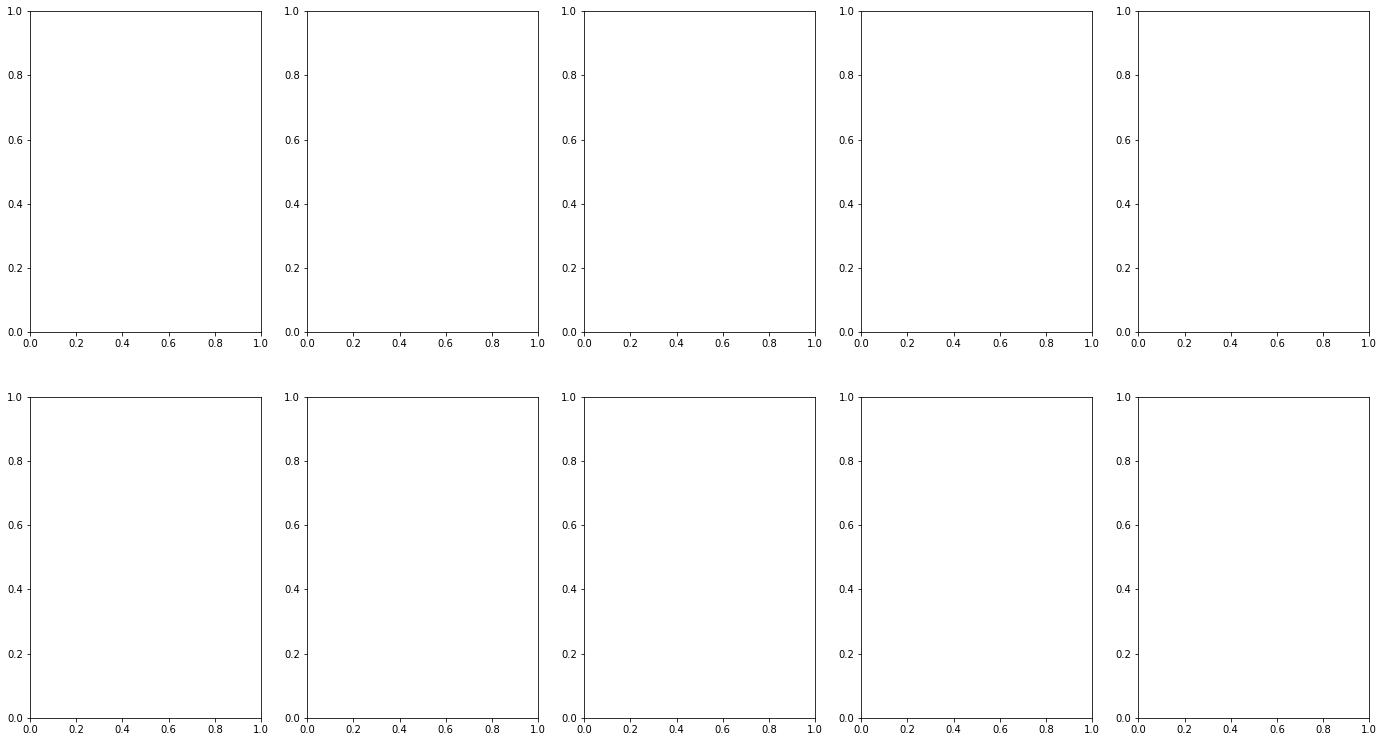

In [101]:
#take expectation value algebraically
from matplotlib import pyplot as plt
shots=2

#rot_ham, rot_ham_noncon, rot_ham_context = rotate_hamiltonian(rotations, ham, ham_noncon, ham_context)

def expectation_optimiser(ham_n, ham_c, p, Z_indices):
    initial_state = '0111101111'
    eigenstate_indices = find_eigenstate_indices(initial_state, Z_indices)
    
    psi = np.array([0 for i in range(2**num_qubits)], dtype=complex)
    for index, i in enumerate(eigenstate_indices):
        psi += (p[index])*add_eigenstate(r1=r1, r2=r2, theta=0, n=0, index=i, num_qubits=num_qubits)
    
    expect_noncon = expectation(ham_n, psi)
    expect_context = expectation(ham_c, psi)
    
    return expect_noncon, expect_context

fig, axs = plt.subplots(nrows = 2, ncols = 5, figsize = (24,13))
grid_pos = [(0,0),(0,1),(0,2),(0,3),(0,4),(1,0),(1,1),(1,2),(1,3),(1,4)]
grid_pos.reverse()

X=list(range(1, shots+1))

random_amplitudes=[]
for i in range(shots):  
    rand_vec = random_vector(len(eigenstate_indices))
    rand_vec = [random_complex_unit()*c for c in rand_vec]
    random_amplitudes.append(rand_vec)

for index, grid in enumerate(grid_pos):
    
    removed_index = list(range(index, 9))
    removed_index.reverse()
    removed_generators = [generators[i] for i in removed_index]
    Z_indices = [g.find('Z') for g in removed_generators]
    print(removed_generators, Z_indices)
    
    new_ham_noncon, new_ham_context = discard_generator(ham_noncon, ham_context, removed_generators)

    #rot_ham_q = q_conv.dict_to_QubitOperator(ham, num_qubits)
    new_ham_noncon_q = q_conv.dict_to_QubitOperator(new_ham_noncon, num_qubits)
    new_ham_context_q = q_conv.dict_to_QubitOperator(new_ham_context, num_qubits)

    eigenstate_indices = find_eigenstate_indices(initial_state, Z_indices)
    
    #amps=[random_vector(len(eigenstate_indices)) for i in range(shots)]
    Y_noncon=[]
    Y_context=[]
    Y_combined=[]
    Y_full=[]

    #A_op = QubitOperator('Y0 Z1 Z2 Z3 Z4 Z5 Y6 Z7', r1) + QubitOperator('Z6', r2)
    #A = LinearQubitOperator(A_op, num_qubits)

    for amps in random_amplitudes:
        expect_noncon, expect_context = expectation_optimiser(new_ham_noncon_q, new_ham_context_q, amps, Z_indices)

        #Y_full.append(expect_full)
        Y_noncon.append(expect_noncon)
        Y_context.append(expect_context)
        Y_combined.append(expect_noncon+expect_context)

        #print(p, expect_noncon + expect_context < gs_noncon_energy)
        #print((np.conjugate(psi)).dot(psi))
        #Verify +1-eigenstate
        #A_psi = A.matvec(psi)
        #print(psi_conj.dot(A_psi))
    
    axs[grid].plot(X, Y_noncon, color='orange')
    #axs[grid].scatter(X, Y_context, color='blue', marker = 'x')
    #axs[grid].plot(X, Y_context, color='blue', ls='--')
    axs[grid].scatter(X, Y_combined, color='black', marker = 'x')
    axs[grid].plot(X, Y_combined, color='black', ls='--')
    #plt.plot(range(shots), Y_combined, color='purple')
    axs[grid].hlines(gs_noncon_energy, 1, shots, color='r')
    axs[grid].hlines(true_gs, 1, shots, color='g')
    
    axs[grid].set_xticks(X)
    axs[grid].set_title("%i generators removed" % abs(index-9))
    if grid[0] == 1:
        axs[grid].set_xlabel('Sample Number',fontsize=16)
    if grid[1] == 0:
        axs[grid].set_ylabel('Energy (Ha)',fontsize=18)
    #print('<H> w.r.t. simultaneous eigenstate:', expect)
    #print('Noncontextual approximation:', gs_noncon_energy)
    #print('Expectation values match?', abs(expect - gs_noncon_energy) < 10**-12) #sanity check - expectation values match? 

In [ ]:
find_eigenstate_indices(initial_state, [])

In [87]:
from openfermion.linalg import LinearQubitOperator

ham_q = q_conv.dict_to_QubitOperator(ham, num_qubits)
ham_noncon_q = q_conv.dict_to_QubitOperator(ham_noncon, num_qubits)
ham_context_q = q_conv.dict_to_QubitOperator(ham_context, num_qubits)

#take expectation value algebraically

for p in np.linspace(0, 1, 1):
    psi = add_eigenstate(r1=r1, r2=r2, index=495, theta=0, n=0, num_qubits=num_qubits)
    expect = expectation(ham_q, psi)
    
    print('<H> w.r.t. simultaneous eigenstate:', expect)
    print('Noncontextual approximation:', gs_noncon_energy)
    print('Expectation values match?', abs(expect - gs_noncon_energy) < 10**-12) #sanity check - expectation values match?

<H> w.r.t. simultaneous eigenstate: (-83.87422390061549+0j)
Noncontextual approximation: -83.87422390061549
Expectation values match? True


[]